In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime
from copy import deepcopy
from collections import Counter
import pickle
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


In [159]:
data = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/Reviews.csv')



In [4]:
data.head(4)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [63]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [64]:
data.isnull().sum()



Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [160]:
# Converting Unix time to date time
data['Time'] = pd.to_datetime(data['Time'],unit='s')
# data_sorted_by_time = data.sort_values('Time')
# Think about it
# It may be useful to implement Hidden Markov Model



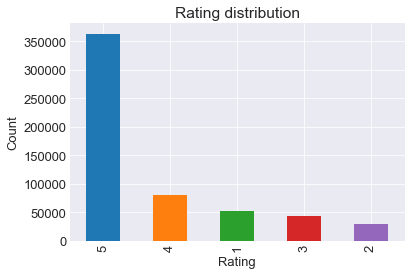

In [116]:
plt.rc('font', size = 13)
data.Score.value_counts().plot(kind = 'bar')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



In [8]:
# "Positive" : 1, "Negative": 0
data['Sentiment'] = data['Score'].apply(lambda score: 1 if score > 3 else 0)



In [68]:
data.Sentiment.value_counts()



1    443777
0    124677
Name: Sentiment, dtype: int64

In [9]:
from nltk.stem.porter import PorterStemmer


# One way to split the text corpora into individual elements is
# to split them into individual words by splitting the cleaned documents 
# at its whitespace characters.

def tokenizer(text):
    return text.split()


# A useful technique in the context of tokenization is word stemming, which
# is the process of transforming a word into its root form. 
# It allows us to map related words to the same stem.

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [10]:
import nltk

nltk.download('stopwords')

# Removing stop-words can be useful if we are working with raw or 
# normalized term frequencies rather than tf-idfs, which are already 
# downweighting frequently occurring words.

from nltk.corpus import stopwords

stop = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javadzabihi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Term Frequency-Inverse Document Frequency

When we are dealing with text data, we often encounter words that occur across multiple documents. Those frequently occurring words typically don't contain useful information. So, we can use a technique called term frequency-inverse document frequency (tf-idf) that can downweight those frequently occurring words in the feature vectors. The tf-idf can be calculated as the product of the term frequency and the inverse document frequency.

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$

$n_d$ : the total number of documents 

df(d, t) : the number of documents 'd' that contain the term 't'

In [11]:
### I'm choosing a very small subset of the dataset to speed up the run
X = data.loc[:500,'Text']
y = data.loc[:500,'Sentiment']



In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)



# Sentiment analysis

# Logistic Regression

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


###### TfidfVectorizer combines the task of CountVectorizer and TfidfTransformer.
# from sklearn.feature_extraction.text import CountVectorizer
# count = CountVectorizer()
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf = TfidfTransformer(use_idf=True, 
#                         norm='l2', 
#                         smooth_idf=True)
# tfidf.fit_transform(count.fit_transform(text)).toarray()

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

# Using a GridSearchCV object to find the optimal set of parameters 
# for our logistic regression model.

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)



In [74]:
gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))



Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   54.5s finished


Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a5cc6e840>, 'vect__use_idf': False} 
CV Accuracy: 0.828
Test Accuracy: 0.861


In [75]:
# The best grid search results using Porter stemming instead of the regular tokenizer, 
# no stop-word library, and a logistic regression classifier 
# that uses L2-regularization with the regularization strength C of 10.0
# based of raw term frequencies.
# regularization strengths is defined by the inverse-regularization parameter C.

# The "gs_lr_tfidf.best_score_" is the average k-fold cross-validation score. 
# For instance, if we have a GridSearchCV object with 10-fold cross-validation, 
# the "best_score_" attribute returns the average score over the 10-folds of the best model.


# Support Vector Classifier

In [76]:
from sklearn.svm import SVC

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [None],
               'vect__tokenizer': [tokenizer_porter],
               'clf__gamma': [0.01, 0.1, 1],
               'clf__C': [0.01, 0.1, 1.0],
               'clf__kernel': ['linear', 'rbf']}]

svc_tfidf = Pipeline([('vect', tfidf), 
                      ('clf', SVC(random_state=1))])

gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)


In [77]:
gs_svc_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_svc_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_svc_tfidf.best_score_)

clf = gs_svc_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))



Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.1s finished


Best parameter set: {'clf__C': 0.01, 'clf__gamma': 0.01, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a5cc6e840>} 
CV Accuracy: 0.818
Test Accuracy: 0.822


The best grid search results using the following values in the support vector classifier:

C = 0.01

gamma = 0.01

kernel = linear

# Naive Bayes

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                       stop_words=None,
                       tokenizer=tokenizer_porter)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)




0.8217821782178217

# Recommendation Engine

In [320]:

# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data.UserId.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data['user_idx'] = data.apply(lambda row: user2idx[row.UserId], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data.ProductId.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data['product_idx'] = data.apply(lambda row: product2idx[row.ProductId], axis=1)




In [319]:
N = data.user_idx.max() + 1
M = data.product_idx.max() + 1
print('Unique number of users: {}'.format(N))
print('Unique number of products: {}'.format(M))




Unique number of users: 256059
Unique number of products: 74258


In [163]:
data_recommender = data.loc[:, ['product_idx', 'user_idx', 'Score', 'Time']]
data_recommender.head(2)



,product_idx,user_idx,Score,Time
0,60979,16433,5,2011-04-27
1,39155,163201,1,2012-09-07


In [14]:
# Calculating the number of unique users and products

n_users = data.user_idx.unique().shape[0]   # 256059
n_products = data.product_idx.unique().shape[0] # 74258



In [15]:
# creating a dataframe with the average rating that each users gave to products

user_ratings = pd.DataFrame(data_recommender.groupby('user_idx')['Score'].mean())
user_ratings.head()



,Score
user_idx,
0,3.000000
1,5.000000
2,5.000000
3,3.428571
4,5.000000


In [16]:
# Adding the number of ratings that each user gave

user_ratings['number_of_ratings'] = data_recommender.groupby('user_idx')['Score'].count()
user_ratings.head()



,Score,number_of_ratings
user_idx,,
0,3.000000,4
1,5.000000,2
2,5.000000,1
3,3.428571,14
4,5.000000,1


In [17]:
user_ratings.sort_values('number_of_ratings', ascending=False).head(6)



,Score,number_of_ratings
user_idx,,
253812,4.535714,448
95089,4.494062,421
176551,4.647815,389
113861,4.841096,365
44584,4.453125,256
108562,4.833333,204


In [18]:
# Let's look at the top of the distribution
user_ratings['number_of_ratings'].quantile(np.arange(.9, 1, .01))
# Around 2% of users gave 12 or more ratings.
# .02 * 256059 ~ 5121



0.90     4.0
0.91     5.0
0.92     5.0
0.93     6.0
0.94     6.0
0.95     7.0
0.96     8.0
0.97     9.0
0.98    12.0
0.99    17.0
Name: number_of_ratings, dtype: float64

In [19]:
# creating a dataframe with the average rating for each product

product_ratings = pd.DataFrame(data_recommender.groupby('product_idx')['Score'].mean())
product_ratings.head()



,Score
product_idx,
0,5.0
1,5.0
2,5.0
3,5.0
4,1.0


In [20]:
# Adding the number of ratings for each product to the ratings dataframe

product_ratings['number_of_ratings'] = data_recommender.groupby('product_idx')['Score'].count()
product_ratings.head()



,Score,number_of_ratings
product_idx,,
0,5.0,1
1,5.0,1
2,5.0,1
3,5.0,2
4,1.0,1


In [21]:
product_ratings.sort_values('number_of_ratings', ascending=False).head(10)



,Score,number_of_ratings
product_idx,,
32171,4.582694,913
6916,4.588608,632
28489,4.588608,632
44621,4.588608,632
71246,4.588608,632
69687,4.739968,623
12915,4.746032,567
52228,4.310284,564
33367,4.310284,564


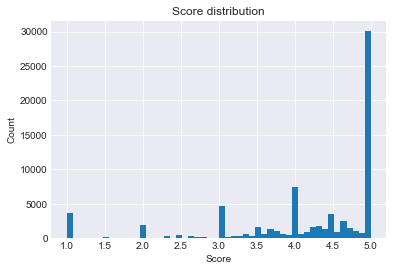

In [22]:
product_ratings['Score'].hist(bins=50)
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()



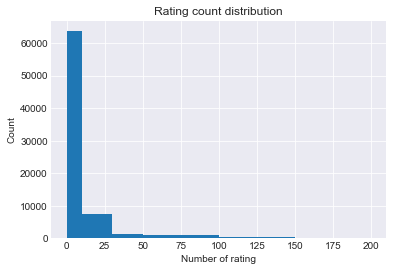

In [23]:
product_ratings['number_of_ratings'].hist(bins=[0, 10, 30, 50, 100, 150, 200])
plt.title('Rating count distribution')
plt.xlabel('Number of rating')
plt.ylabel('Count')
plt.show()



In [24]:
# Statistics of number of ratings
product_ratings['number_of_ratings'].describe()



count    74258.000000
mean         7.655121
std         26.453485
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
Name: number_of_ratings, dtype: float64

In [25]:
# Let's look at the top of the distribution
product_ratings['number_of_ratings'].quantile(np.arange(.9, 1, .01))
# Around 3% of products received 41 or more ratings.
# .03 * 74258 ~ 2227



0.90     13.0
0.91     15.0
0.92     17.0
0.93     19.0
0.94     22.0
0.95     26.0
0.96     31.0
0.97     41.0
0.98     61.0
0.99    111.0
Name: number_of_ratings, dtype: float64

In [164]:
user_ids_count = Counter(data_recommender.user_idx)
product_ids_count = Counter(data_recommender.product_idx)

# TO work with a smaller dataset, we just take a subset of dataset into account
# Accodring to our previous calculation, we just keep top 5000 users who gave the highest number of ratings
# and top 2000 products which received the highest number of ratings

n = 5000
m = 2000

# The result of "most_common" is a tuple that the first item is the key
# and the second one is the count.
# I just need the first item which is the key(user or product).
user_ids = [u for u, c in user_ids_count.most_common(n)]
product_ids = [p for p, c in product_ids_count.most_common(m)]


In [165]:
# Use ".copy()" to overwrite the data
data_small = data_recommender[data_recommender.user_idx.isin(user_ids) & 
                              data_recommender.product_idx.isin(product_ids)].copy()



In [28]:
data_small.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 69956 entries, 422 to 568062
Data columns (total 4 columns):
product_idx    69956 non-null int64
user_idx       69956 non-null int64
Score          69956 non-null int64
Time           69956 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.7 MB


In [166]:
# Right now our user ids and product ids are not sequential,
# so we make them sequential with a similar mapping as we have done before.
# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data_small.user_idx.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data_small['user_idx'] = data_small.apply(lambda row: user2idx[row.user_idx], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data_small.product_idx.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data_small['product_idx'] = data_small.apply(lambda row: product2idx[row.product_idx], axis=1)



In [169]:
print("max user id:", data_small.user_idx.max())
print("max product id:", data_small.product_idx.max())
print("small dataframe size:", len(data_small))
data_small.to_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/small_rating.csv', index=False)



max user id: 4638
max product id: 1974
small dataframe size: 69956


In [170]:
small_rating = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/small_rating.csv')



In [171]:
small_rating.head()



,product_idx,user_idx,Score,Time
0,842,1348,4,2012-04-26
1,842,1959,5,2012-04-17
2,842,1837,5,2012-04-13
3,842,2497,4,2012-04-10
4,842,2497,4,2012-04-10


In [172]:



N = small_rating.user_idx.max() + 1 # number of users
M = small_rating.product_idx.max() + 1 # number of products

# split into train and test
small_rating = shuffle(small_rating)
cutoff = int(0.8*len(small_rating))
small_rating_train = small_rating.iloc[:cutoff]
small_rating_test = small_rating.iloc[cutoff:]

# a dictionary to tell us which users have rated which products
user2product = {}
# a dicationary to tell us which products have been rated by which users
product2user = {}
# a dictionary to look up ratings
userproduct2rating = {}

count = 0

def update_user2product_and_product2user(row):

    i = int(row.user_idx)
    j = int(row.product_idx)
    if i not in user2product:
        user2product[i] = [j]
    else:
        user2product[i].append(j)

    if j not in product2user:
        product2user[j] = [i]
    else:
        product2user[j].append(i)

    userproduct2rating[(i,j)] = row.Score
    
small_rating_train.apply(update_user2product_and_product2user, axis=1)


37080    None
58064    None
13748    None
47659    None
25277    None
4336     None
21044    None
61938    None
39791    None
28106    None
56261    None
3570     None
15852    None
68842    None
36812    None
33201    None
35016    None
11745    None
47891    None
32681    None
3670     None
32382    None
13423    None
52213    None
14261    None
34183    None
56251    None
36088    None
51965    None
47794    None
         ... 
46497    None
28802    None
37583    None
43742    None
8946     None
23595    None
60080    None
66194    None
7942     None
28970    None
30118    None
41522    None
27643    None
14049    None
9277     None
4533     None
33746    None
16130    None
12489    None
56183    None
13484    None
33353    None
60426    None
14019    None
57221    None
36072    None
39262    None
15166    None
68531    None
55147    None
Length: 55964, dtype: object

In [173]:
# test ratings dictionary
userproduct2rating_test = {}

count = 0
def update_userproduct2rating_test(row):

    i = int(row.user_idx)
    j = int(row.product_idx)
    userproduct2rating_test[(i,j)] = row.Score
small_rating_test.apply(update_userproduct2rating_test, axis=1)


14358    None
49977    None
22274    None
45513    None
56357    None
18979    None
38143    None
7534     None
35843    None
55299    None
44597    None
7460     None
10180    None
23199    None
64161    None
62521    None
59806    None
1994     None
46119    None
5264     None
19505    None
37412    None
25180    None
40004    None
41257    None
60624    None
20736    None
62909    None
3115     None
39580    None
         ... 
49307    None
59327    None
67112    None
56114    None
57552    None
42252    None
47517    None
60322    None
51871    None
39867    None
60874    None
33173    None
15157    None
68817    None
69284    None
18618    None
7920     None
44345    None
48136    None
15797    None
35198    None
44815    None
40299    None
30677    None
10937    None
57447    None
2701     None
38731    None
3818     None
53804    None
Length: 13992, dtype: object

In [174]:
# Save these dictionaries
with open('user2product.json', 'wb') as f:
    pickle.dump(user2product, f)

with open('product2user.json', 'wb') as f:
    pickle.dump(product2user, f)

with open('userproduct2rating.json', 'wb') as f:
    pickle.dump(userproduct2rating, f)

with open('userproduct2rating_test.json', 'wb') as f:
    pickle.dump(userproduct2rating_test, f)
    
    

# User-based collaborative filtering


* A user can be biased (optimistically or pessimistically)
* We will look at average deviation rather than average ratings


$$\huge S(u,i) = \bar r_{u} +\frac{\sum_{u' \in k}(r_{u',i} - \bar r_{u'})\times W_{u,u'}}{\sum_{u' \in k}W_{u,u'}}$$


* u: user u
* i: item i
* u': user u'
* k: Number of users that have the highest similar taste with the user u
* S(u,i): Rating for item i given by user u
* W(u,u'): Similarity between users u and u' 
* r(u',i): Rating for item i given by user u'

In [175]:
with open('user2product.json', 'rb') as f:
    user2product = pickle.load(f)

with open('product2user.json', 'rb') as f:
    product2user = pickle.load(f)

with open('userproduct2rating.json', 'rb') as f:
    userproduct2rating = pickle.load(f)

with open('userproduct2rating_test.json', 'rb') as f:
    userproduct2rating_test = pickle.load(f)
    
    

In [176]:
N = np.max(list(user2product.keys())) + 1
# the test set may contain products the train set doesn't have data on
m1 = np.max(list(product2user.keys()))
m2 = np.max([m for (u, m), r in userproduct2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)



N: 4639 M: 1975


In [317]:
# Basically we want to find k neigherest neighbors to each user according to their taste
# in choosing a product and rating it, and then we want to use it to predict what
# would be a user's rating for a product that he has not rated yet.
from sortedcontainers import SortedList
# number of neighbors we would like to take into account
K = 25 
# number of products users must have in common in order to consider them
limit = 5 
# store neighbors
neighbors = [] 
# each user's average rating
averages = [] 
# each user's rating deviation from his average rating
deviations = [] 


for i in range(N):
    # find the 25 closest users to user i
    try:
        products_i = user2product[i]
        products_i_set = set(products_i)

        # calculate avg and deviation
        ratings_i = { product:userproduct2rating[(i, product)] for product in products_i }
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = { product:(rating - avg_i) for product, rating in ratings_i.items() }
        dev_i_values = np.array(list(dev_i.values()))
        sigma_i = np.sqrt(dev_i_values.dot(dev_i_values))

        # save these for later use
        averages.append(avg_i)
        deviations.append(dev_i)

        sl = SortedList()
    except KeyError:
        pass

    try:    
        for j in range(N):
        # don't include yourself

            if j != i:
                products_j = user2product[j]
                products_j_set = set(products_j)
                common_products = (products_i_set & products_j_set) # intersection


                if len(common_products) > limit:
                    # calculate avg and deviation
                    ratings_j = { product:userproduct2rating[(j, product)] for product in products_j }
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = { product:(rating - avg_j) for product, rating in ratings_j.items() }
                    dev_j_values = np.array(list(dev_j.values()))
                    sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

                    # calculate correlation coefficient
                    numerator = sum(dev_i[m]*dev_j[m] for m in common_products)
                    w_ij = numerator / (sigma_i * sigma_j)

                    # insert into sorted list and truncate
                    # negate weight, because list is sorted ascending
                    # maximum value (1) is "closest"
                    sl.add((-w_ij, j))
                    if len(sl) > K:
                        del sl[-1]

        # store the neighbors
        neighbors.append(sl)
    except KeyError:
        pass


# using neighbors, calculate train and test MSE

def predict(i, m):
    # calculate the weighted sum of deviations
    numerator = 0
    denominator = 0

    for neg_w, j in neighbors[i]:
        # remember, the weight is stored as its negative
        # so the negative of the negative weight is the positive weight
        try:
            numerator += -neg_w * deviations[j][m]
            denominator += abs(neg_w)
        except KeyError:       
            pass
                # neighbor may not have rated the same product
                # don't want to do dictionary lookup twice
                # so just throw exception
    
    if denominator == 0:
        prediction = averages[i]
    else:
        prediction = numerator / denominator + averages[i]
    prediction = min(5, prediction)
    prediction = max(0.5, prediction) # min rating is 0.5
    return prediction
    
    

train_predictions = []
train_targets = []
try:
    for (i, m), target in userproduct2rating.items():
    # calculate the prediction for this product
    
        prediction = predict(i, m)

    # save the prediction and target
        train_predictions.append(prediction)
        train_targets.append(target)
except KeyError:
    pass
test_predictions = []
test_targets = []
# same thing for test set
try:
    for (i, m), target in userproduct2rating_test.items():
    # calculate the prediction for this product
    
        prediction = predict(i, m)

        # save the prediction and target
        test_predictions.append(prediction)
        test_targets.append(target)
except KeyError:
    pass   


# calculate accuracy
def mse(p, t):
    p = np.array(p)
    t = np.array(t)
    return np.mean((p - t)**2)

print('train mse:', mse(train_predictions, train_targets))
print('test mse:', mse(test_predictions, test_targets))

# I'm facing "IndexError" when I'm running this block of code!
# Righ now I'm so frustrated, I will take a look in the near future to see what's wrong!!


IndexError: list index out of range

# Collaborative Filtering (Cosine Similarity)

In [177]:
small_rating.head()



,product_idx,user_idx,Score,Time
37080,244,2794,5,2012-01-01
58064,316,2367,5,2010-06-23
13748,515,4231,4,2012-01-04
47659,256,496,5,2011-06-06
25277,1588,241,5,2011-06-15


In [250]:
n_users = small_rating.user_idx.unique().shape[0]
n_items = small_rating.product_idx.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

4639 users
1975 items


In [276]:
# Constructing our user-item matrix
ratings = np.zeros((n_users, n_items))
for row in small_rating.itertuples():
    ratings[row[2], row[1]] = row[3]
ratings

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]])

In [278]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))
# Just 0.71% of the user-item ratings have a value!

Sparsity: 0.71%


In [279]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)



# Cosine similarity for user u and u'

$$\large Sim(u, u') = \cos(\theta) = \frac{r_{u}.r_{u'}}{|r_{u}||r_{u'}|} = \frac{\sum_i r_{ui}r_{u'i}}{\sqrt{\sum_i r_{ui}^2}\sqrt{\sum_i r_{u'i}^2}} $$

In [280]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [284]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print ('----------- User Similarity -----------')
print (user_similarity[:4, :4])
print ('----------- Product Similarity -----------')
print (item_similarity[:4, :4])

----------- User Similarity -----------
[[1.000000e+00 3.002516e-12 4.191297e-12 4.216370e-12]
 [3.002516e-12 1.000000e+00 2.831498e-12 2.848436e-12]
 [4.191297e-12 2.831498e-12 1.000000e+00 3.976214e-12]
 [4.216370e-12 2.848436e-12 3.976214e-12 1.000000e+00]]
----------- Product Similarity -----------
[[1.000000e+00 1.656744e-12 1.261712e-12 6.102479e-13]
 [1.656744e-12 1.000000e+00 1.603287e-12 1.938640e-02]
 [1.261712e-12 1.603287e-12 1.000000e+00 5.905572e-13]
 [6.102479e-13 1.938640e-02 5.905572e-13 1.000000e+00]]


### To predict the user u's rating given to item i, we can use the weighted sum of all other users' rating to item i where the weighting is the cosine similarity between user u and the other users.

$$\large \hat r_{ui} = \frac {\sum_{u'} Sim(u, u')r_{u'i}}{\sum_{u'} |Sim(u, u')|}$$

In [285]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [307]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [308]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 17.540439334040997
Item-based CF MSE: 17.831646495694304


# Top-k Collaborative Filtering

* We will only take the top k users who are most similar to the input user into account.

In [297]:
def predict_topk(ratings, similarity, kind='user', k=10):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [309]:
pred = predict_topk(train, user_similarity, kind='user', k=10)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=10)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 17.887291940936574
Top-k Item-based CF MSE: 17.866648631052456


In [300]:
k_array = [5, 10, 15, 20, 25, 30]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

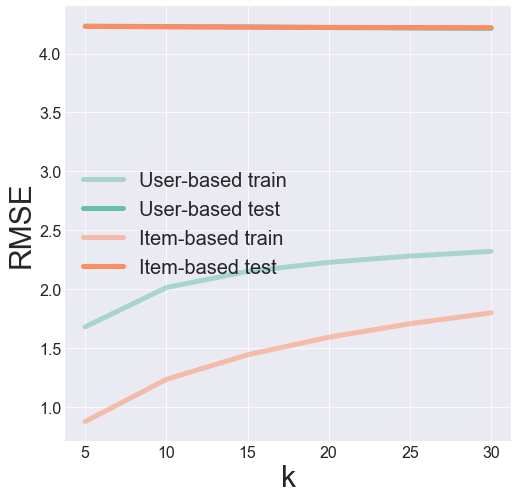

In [303]:
sns.set_style('darkgrid')
pal = sns.color_palette("Set2", 2)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# Bias-subtracted Collaborative Filtering

* Users may tend to always give high or low ratings to all movies. As a results, it seems that the relative difference in the ratings that these users give is more important than the absolute rating values.
* A user can be biased (optimistically or pessimistically)
* We will look at average deviation rather than average ratings



$$\large \hat r_{ui} = \bar r_{u} + \frac {\sum_{u'} Sim(u, u')(r_{u'i} - \bar r_{u'} )}{\sum_{u'} |Sim(u, u')|}$$

In [304]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [310]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print ('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print ('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))


Bias-subtracted User-based CF MSE: 17.583900644184723
Bias-subtracted Item-based CF MSE: 17.65915074234725


# Combining Top-k and Bias-subtracted Collaborative Filtering

In [313]:
def predict_topk_nobias(ratings, similarity, kind='user', k=10):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [314]:
user_pred = predict_topk_nobias(train, user_similarity, kind='user')
print ('Top-k Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_topk_nobias(train, item_similarity, kind='item')
print ('Top-k Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Top-k Bias-subtracted User-based CF MSE: 17.862079796434966
Top-k Bias-subtracted Item-based CF MSE: 17.898148545803153


In [315]:
k_array = [5, 10, 15, 20, 25, 30]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

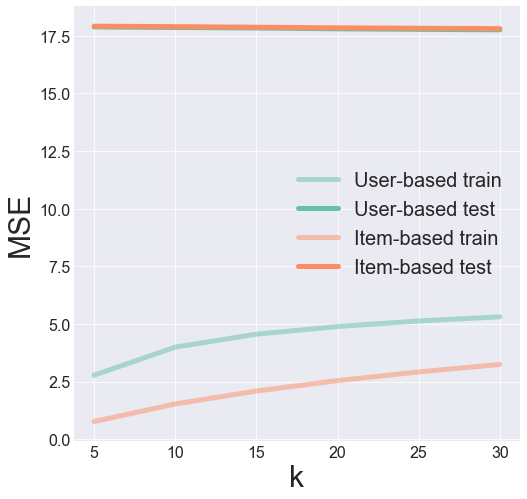

In [316]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# Collaborative filtering by 'Surprise' package

In [202]:
# https://surprise.readthedocs.io/en/stable/getting_started.html

from surprise import Reader, Dataset, KNNBasic, evaluate    

data_surprise = small_rating.loc[: , ['user_idx', 'product_idx', 'Score']]

reader = Reader()

dataset = Dataset.load_from_df(data_surprise, reader)

# KNN
knn = KNNBasic()

evaluate(knn, dataset, measures = ['RMSE'])



Evaluating RMSE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7304
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7120
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7384
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7301
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7238
------------
------------
Mean RMSE: 0.7269
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.730440719995921,
                             0.7119559829635306,
                             0.7384038793018061,
                             0.7300556464747818,
                             0.7237970128039715]})

In [203]:
from surprise import SVD

# Singular Value Decomposition
svd = SVD()

evaluate(svd, dataset, measures = ['RMSE'])


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.7582
------------
Fold 2
RMSE: 0.7458
------------
Fold 3
RMSE: 0.7637
------------
Fold 4
RMSE: 0.7653
------------
Fold 5
RMSE: 0.7545
------------
------------
Mean RMSE: 0.7575
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.7581980479377114,
                             0.7458063815611947,
                             0.7636922120628178,
                             0.7652889253942499,
                             0.75452340696159]})

In [204]:
from surprise import NMF

# Non negative Matrix Factorization
nmf = NMF()

evaluate(nmf, dataset, measures = ['RMSE'])



Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.7362
------------
Fold 2
RMSE: 0.7548
------------
Fold 3
RMSE: 0.7512
------------
Fold 4
RMSE: 0.7647
------------
Fold 5
RMSE: 0.7386
------------
------------
Mean RMSE: 0.7491
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.7362486290592594,
                             0.7547521626858709,
                             0.7512052365374222,
                             0.7647384077148527,
                             0.7386306278874271]})

In [130]:

from surprise import GridSearch


param_grid = {'lr_all': [0.007, 0.008, 0.009],
              'reg_all': [0.1, 0.2, 0.3]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(dataset)



Running grid search for the following parameter combinations:
{'lr_all': 0.007, 'reg_all': 0.1}
{'lr_all': 0.007, 'reg_all': 0.2}
{'lr_all': 0.007, 'reg_all': 0.3}
{'lr_all': 0.008, 'reg_all': 0.1}
{'lr_all': 0.008, 'reg_all': 0.2}
{'lr_all': 0.008, 'reg_all': 0.3}
{'lr_all': 0.009, 'reg_all': 0.1}
{'lr_all': 0.009, 'reg_all': 0.2}
{'lr_all': 0.009, 'reg_all': 0.3}
Resulsts:
{'lr_all': 0.007, 'reg_all': 0.1}
{'RMSE': 0.7375922328542653}
----------
{'lr_all': 0.007, 'reg_all': 0.2}
{'RMSE': 0.767988277403472}
----------
{'lr_all': 0.007, 'reg_all': 0.3}
{'RMSE': 0.796003413366109}
----------
{'lr_all': 0.008, 'reg_all': 0.1}
{'RMSE': 0.7241446036693646}
----------
{'lr_all': 0.008, 'reg_all': 0.2}
{'RMSE': 0.7568968410766128}
----------
{'lr_all': 0.008, 'reg_all': 0.3}
{'RMSE': 0.7864989847746469}
----------
{'lr_all': 0.009, 'reg_all': 0.1}
{'RMSE': 0.7133740946274288}
----------
{'lr_all': 0.009, 'reg_all': 0.2}
{'RMSE': 0.7475158004561825}
----------
{'lr_all': 0.009, 'reg_all': 0.3

# Matrix Factorization with bias terms and regularization




$$\huge \hat r_{ij} = w_{i}^{T}u_{j} + b_{i} + c_{j} + \mu$$



* W(i): User vector
* u(j): Product vector
* b(i) : User bias
* c(i) : Product bias
* mu : Global average


$$\large J = \sum_{i,j \in \Omega}(r_{ij} - \hat r_{ij})^2 + \lambda (||W||_{F}^2 + ||U||_{F}^2 + ||b||_{F}^2 + ||c||_{F}^2)$$

* J: Loss function
* omega: Set of pairs (i,j) where user i rated product j
* Lambda : Regularization parameter

$$||W||_{F}^2 = \sum_{i=1}^{N} \sum_{k=1}^{K}|w_{ik}|^2 = \sum_{i=1}^{N}||w_{i}||_{2}^2 = \sum_{i=1}^{N}w_{i}^{T}w_{i}$$

# Minimizing loss function

* Set derivatives to zero and solve for w, u, b, and c


$$\large W_{i} = \left(\sum_{j \in \psi_{i}}u_{j}u_{j}^T + \lambda I\right)^{-1} \sum_{j \in \psi_{i}}(r_{ij} - b_{i} - c_{j} - \mu)u_{j}$$







$$\large u_{j} = \left(\sum_{i \in \Omega_{j}}W_{i}W_{i}^T + \lambda I\right)^{-1} \sum_{i \in \Omega_{j}}(r_{ij} - b_{i} - c_{j} - \mu)W_{i}$$










$$\large b_{i} = \frac{1}{\mid\psi_{i}\mid(1 + \lambda)} \sum_{j \in \psi_{i}}(r_{ij} - W_{i}^{T}u_{j} - c_{j} - \mu)$$








$$\large c_{j} = \frac{1}{\mid\Omega_{j}\mid(1 + \lambda)} \sum_{i \in \Omega_{j}}(r_{ij} - W_{i}^{T}u_{j} - b_{i} - \mu)$$







* Psi(i) : All products j that user i rated
* Omega(j) : All users i who rated product j

In [ ]:
with open('user2product.json', 'rb') as f:
    user2product = pickle.load(f)

with open('product2user.json', 'rb') as f:
    product2user = pickle.load(f)

with open('userproduct2rating.json', 'rb') as f:
    userproduct2rating = pickle.load(f)

with open('userproduct2rating_test.json', 'rb') as f:
    userproduct2rating_test = pickle.load(f)
   

In [ ]:
N = np.max(list(user2product.keys())) + 1
# the test set may contain products the train set doesn't have data on
m1 = np.max(list(product2user.keys()))
m2 = np.max([m for (u, m), r in userproduct2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)


epoch: 0
i: 0 N: 4639
i: 463 N: 4639
i: 926 N: 4639
i: 1389 N: 4639
i: 1852 N: 4639
i: 2315 N: 4639
i: 2778 N: 4639
i: 3241 N: 4639
i: 3704 N: 4639
i: 4167 N: 4639
i: 4630 N: 4639
updated W and b: 0:00:01.025218
j: 0 M: 1975
j: 197 M: 1975
j: 394 M: 1975
j: 591 M: 1975
j: 788 M: 1975
j: 985 M: 1975
j: 1182 M: 1975
j: 1379 M: 1975
j: 1576 M: 1975
j: 1773 M: 1975
j: 1970 M: 1975
updated U and c: 0:00:00.931250
epoch duration: 0:00:01.956699
calculate cost: 0:00:00.140208
train loss: 0.8818342374577052
test loss: 0.9291581166844034
epoch: 1
i: 0 N: 4639
i: 463 N: 4639
i: 926 N: 4639
i: 1389 N: 4639
i: 1852 N: 4639
i: 2315 N: 4639
i: 2778 N: 4639
i: 3241 N: 4639
i: 3704 N: 4639
i: 4167 N: 4639
i: 4630 N: 4639
updated W and b: 0:00:01.060744
j: 0 M: 1975
j: 197 M: 1975
j: 394 M: 1975
j: 591 M: 1975
j: 788 M: 1975
j: 985 M: 1975
j: 1182 M: 1975
j: 1379 M: 1975
j: 1576 M: 1975
j: 1773 M: 1975
j: 1970 M: 1975
updated U and c: 0:00:01.182696
epoch duration: 0:00:02.243760
calculate cost: 0:00:0

j: 394 M: 1975
j: 591 M: 1975
j: 788 M: 1975
j: 985 M: 1975
j: 1182 M: 1975
j: 1379 M: 1975
j: 1576 M: 1975
j: 1773 M: 1975
j: 1970 M: 1975
updated U and c: 0:00:00.928426
epoch duration: 0:00:01.921592
calculate cost: 0:00:00.145962
train loss: 0.8232528033947735
test loss: 0.8546138925198185
epoch: 16
i: 0 N: 4639
i: 463 N: 4639
i: 926 N: 4639
i: 1389 N: 4639
i: 1852 N: 4639
i: 2315 N: 4639
i: 2778 N: 4639
i: 3241 N: 4639
i: 3704 N: 4639
i: 4167 N: 4639
i: 4630 N: 4639
updated W and b: 0:00:01.003529
j: 0 M: 1975
j: 197 M: 1975
j: 394 M: 1975
j: 591 M: 1975
j: 788 M: 1975
j: 985 M: 1975
j: 1182 M: 1975
j: 1379 M: 1975
j: 1576 M: 1975
j: 1773 M: 1975
j: 1970 M: 1975
updated U and c: 0:00:00.926888
epoch duration: 0:00:01.930688
calculate cost: 0:00:00.136000
train loss: 0.8232180017835441
test loss: 0.8545931599681843
epoch: 17
i: 0 N: 4639
i: 463 N: 4639
i: 926 N: 4639
i: 1389 N: 4639
i: 1852 N: 4639
i: 2315 N: 4639
i: 2778 N: 4639
i: 3241 N: 4639
i: 3704 N: 4639
i: 4167 N: 4639
i: 4

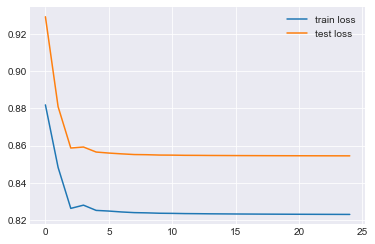

In [223]:

# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(userproduct2rating.values()))


# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

def get_loss(d):
  # d: (user_id, movie_id) -> rating
    N = float(len(d)) 
    # Sum of squared error
    sse = 0
    for k, r in d.items():
        i, j = k
        p = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (p - r)*(p - r)
    # Root mean squared error    
    return np.sqrt(sse / N)


# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
    # perform updates

    # update W and b
    t0 = datetime.now()
    for i in range(N):
        # for W
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for b
        bi = 0
        try:
            for j in user2product[i]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(U[j], U[j])
                vector += (r - b[i] - c[j] - mu)*U[j]
                bi += (r - W[i].dot(U[j]) - c[j] - mu)

            # set the updates
            W[i] = np.linalg.solve(matrix, vector)
            b[i] = bi / (len(user2product[i]) + reg)

            if i % (N//10) == 0:
                print("i:", i, "N:", N)
        except KeyError:
            pass
    print("updated W and b:", datetime.now() - t0)

  # update U and c
    t0 = datetime.now()
    for j in range(M):
        # for U
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for c
        cj = 0
        try:
            for i in product2user[j]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - b[i] - c[j] - mu)*W[i]
                cj += (r - W[i].dot(U[j]) - b[i] - mu)

      # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(product2user[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
            # possible not to have any ratings for a product
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(userproduct2rating))

    # store test loss
    test_losses.append(get_loss(userproduct2rating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()




# Matrix Factorization -  Vectorized

converting...
conversion done
epoch: 0
i: 0 N: 256059
updated W and b: 0:00:00.387225
j: 0 M: 74258
updated U and c: 0:00:00.161786
epoch duration: 0:00:00.549419
calculate cost: 0:00:00.059030
train loss: 0.7613553421209877
test loss: 0.8498246390214241
epoch: 1
i: 0 N: 256059
updated W and b: 0:00:00.362304
j: 0 M: 74258
updated U and c: 0:00:00.162751
epoch duration: 0:00:00.525286
calculate cost: 0:00:00.058032
train loss: 0.7045639456375368
test loss: 0.7740760397748166
epoch: 2
i: 0 N: 256059
updated W and b: 0:00:00.368799
j: 0 M: 74258
updated U and c: 0:00:00.162769
epoch duration: 0:00:00.531811
calculate cost: 0:00:00.054291
train loss: 0.6675409896910375
test loss: 0.7357717883804901
epoch: 3
i: 0 N: 256059
updated W and b: 0:00:00.373366
j: 0 M: 74258
updated U and c: 0:00:00.162628
epoch duration: 0:00:00.536791
calculate cost: 0:00:00.059243
train loss: 0.6708568269950501
test loss: 0.7371606323082761
epoch: 4
i: 0 N: 256059
updated W and b: 0:00:00.375100
j: 0 M: 74258


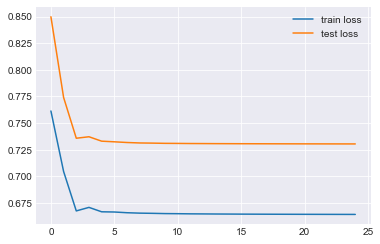

In [245]:
# convert user2product and product2user to include ratings
print("converting...")
user2productrating = {}
for i, products in user2product.items():
    r = np.array([userproduct2rating[(i,j)] for j in products])
    user2productrating[i] = (products, r)
product2userrating = {}
for j, users in product2user.items():
    r = np.array([userproduct2rating[(i,j)] for i in users])
    product2userrating[j] = (users, r)

# create a product2user for test set, since we need it for loss
product2userrating_test = {}
for (i, j), r in userproduct2rating_test.items():
    if j not in product2userrating_test:
        product2userrating_test[j] = [[i], [r]]
    else:
        product2userrating_test[j][0].append(i)
        product2userrating_test[j][1].append(r)
for j, (users, r) in product2userrating_test.items():
    product2userrating_test[j][1] = np.array(r)
print("conversion done")

# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(userproduct2rating.values()))



def get_loss(m2u):
  # d: movie_id -> (user_ids, ratings)
    N = 0.
    sse = 0
    for j, (u_ids, r) in m2u.items():
        p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
        delta = p - r
        sse += delta.dot(delta)
        N += len(r)
    return sse / N



# train the parameters
epochs = 25
reg = 20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
  # perform updates

  # update W and b
    t0 = datetime.now()
    for i in range(N):
        try:
            m_ids, r = user2productrating[i]
            matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
            vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
            bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

            # set the updates
            W[i] = np.linalg.solve(matrix, vector)
            b[i] = bi / (len(user2product[i]) + reg)

            if i % (N//10) == 0:
                print("i:", i, "N:", N)
        except KeyError:
            pass
    print("updated W and b:", datetime.now() - t0)


    # update U and c
    t0 = datetime.now()
    for j in range(M):
        try:
            u_ids, r = product2userrating[j]
            matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
            vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
            cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

            # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(product2user[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
          # possible not to have any ratings for a product
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(product2userrating))

    # store test loss
    test_losses.append(get_loss(product2userrating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()





# Matrix Factorization in Keras




In [241]:

df = data_recommender.copy()
df.head(3)


,product_idx,user_idx,Score,Time
0,60979,16433,5,2011-04-27
1,39155,163201,1,2012-09-07
2,68680,145973,4,2008-08-18


Using TensorFlow backend.


Train on 454763 samples, validate on 113691 samples
Epoch 1/15
454763/454763 [==============================] - 119s 261us/step - loss: 1.6125 - mean_squared_error: 1.6125 - val_loss: 1.5594 - val_mean_squared_error: 1.5594
Epoch 2/15
454763/454763 [==============================] - 136s 298us/step - loss: 1.4474 - mean_squared_error: 1.4474 - val_loss: 1.4869 - val_mean_squared_error: 1.4869
Epoch 3/15
454763/454763 [==============================] - 137s 302us/step - loss: 1.3361 - mean_squared_error: 1.3361 - val_loss: 1.4355 - val_mean_squared_error: 1.4355
Epoch 4/15
454763/454763 [==============================] - 137s 302us/step - loss: 1.2472 - mean_squared_error: 1.2472 - val_loss: 1.3946 - val_mean_squared_error: 1.3946
Epoch 5/15
454763/454763 [==============================] - 138s 304us/step - loss: 1.1720 - mean_squared_error: 1.1720 - val_loss: 1.3606 - val_mean_squared_error: 1.3606
Epoch 6/15
454763/454763 [==============================] - 144s 317us/step - loss: 1.10

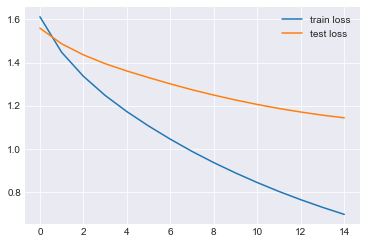

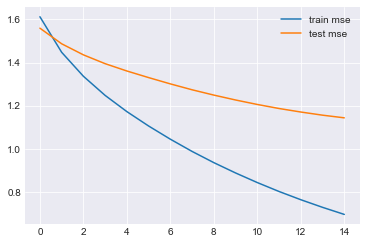

In [242]:

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam


N = df.user_idx.max() + 1 # number of users
M = df.product_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.Score.mean()
epochs = 15
reg = 0. # regularization penalty


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)

# subsubmodel = Model([u, m], [u_embedding, m_embedding])
# user_ids = df_train.user_idx.values[0:5]
# product_ids = df_train.product_idx.values[0:5]
# print("user_ids.shape", user_ids.shape)
# p = subsubmodel.predict([user_ids, product_ids])
# print("p[0].shape:", p[0].shape)
# print("p[1].shape:", p[1].shape)
# exit()


u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)

# submodel = Model([u, m], x)
# user_ids = df_train.user_idx.values[0:5]
# product_ids = df_train.product_idx.values[0:5]
# p = submodel.predict([user_ids, product_ids])
# print("p.shape:", p.shape)
# exit()


x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[df_train.user_idx.values, df_train.product_idx.values],
  y=df_train.Score.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.user_idx.values, df_test.product_idx.values],
    df_test.Score.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()




